In [1]:
# IMPORTS

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import ast
from matplotlib.animation import FuncAnimation, PillowWriter
from geopy import distance
from sklearn import linear_model

plt.ioff()

In [2]:
# # IMPORT DATA

# directory = '.\Data'
# all_files = os.listdir(directory)
# csv_files = [f for f in all_files if f.startswith('CAMP') and f.endswith('csv')]

# data_list = []

# for file in csv_files:
#     file_path = os.path.join(directory, file)
#     df = pd.read_csv(file_path, encoding='latin-1')
#     data_list.append(df)

# data_concat = pd.concat(data_list, ignore_index=True)

# # DROP UNUSED COLUMNS
# data_concat = data_concat.drop(columns=['OBJECTID', 'NUMERO_ORDINE', 'TECNICO', 'ID', 'TIPOLOGIA'])

# # ADJUST DATE FORMAT
# data_concat['DATA_RILEVAMENTO'] = pd.to_datetime(data_concat.DATA_RILEVAMENTO, format='mixed')

# # ADJUST SPECIES NAMES
# # Remove non-species
# data_concat = data_concat[~data_concat['SPECIE'].isin(['06', '****', 'nan']) & ~data_concat['SPECIE'].isna()]

# # Group same species under same name (replacement dictionaries are in 'Species.txt')
# with open('Species.txt', 'r') as file:
#     file_content = file.read()

# replacement_dict_list = ast.literal_eval(file_content)
# for replacement_dict in replacement_dict_list:
#     data_concat['SPECIE'] = data_concat['SPECIE'].replace(replacement_dict)

# # ADJUST CASE IN OTHER COLUMNS
# column_list = ['CULTIVAR', 'RISULTATO', 'COMUNE', 'SINTOMO']

# for column in column_list:
#     data_concat[column] = data_concat[column].str.capitalize()

# # SORT BY DATE
# data_concat = data_concat.sort_values(by='DATA_RILEVAMENTO')

# # REMOVE ROWS WITH NO COORDINATE DATA
# data_concat = data_concat.dropna(subset=['LATITUDINE', 'LONGITUDINE'])

# # REMOVE WRONG DATA
# lat_min = 39.0
# lon_max = 18.9
# mask = (data_concat['LATITUDINE'] < lat_min) & (data_concat['LONGITUDINE'] > lon_max)
# data_concat = data_concat[~mask]

# # EXPORT CLEANED DATAFRAME
# data_concat.to_csv('.\Data\Dati_monitoraggio_2013-2023.csv', index=False)


In [3]:
# IMPORT CLEANED DATAFRAME
data_concat = pd.read_csv('.\Data\Dati_monitoraggio_2013-2023.csv', low_memory=False)
data_concat['DATA_RILEVAMENTO'] = pd.to_datetime(data_concat['DATA_RILEVAMENTO'])

In [4]:
# CREATE MAP FUNCTION
def create_map(limits, ax, resolution):
    lat_min, lat_max, lon_min, lon_max = limits
    m = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2, lon_0=(lon_max-lon_min)/2,
                projection='merc', resolution=resolution, area_thresh=10000., ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmapboundary(fill_color='#46bcec')
    m.fillcontinents(color='white',lake_color='#46bcec')
    return m

# MAP LIMITS
def get_limits(lat, lon, margin=0.1):    
    lat_min = np.min(lat) - margin
    lat_max = np.max(lat) + margin
    lon_min = np.min(lon) - margin
    lon_max = np.max(lon) + margin
    limits = [lat_min, lat_max, lon_min, lon_max]
    return limits

In [5]:
# MODIFY ORIGINAL DATAFRAME
color_map = {'Positivo': 'red', 'Negativo': 'green'}
data_concat['COLOR'] = data_concat['RISULTATO'].map(color_map)

# GLOBAL VARIABLES
lat = data_concat['LATITUDINE'].values
lon = data_concat['LONGITUDINE'].values
limits = get_limits(lat, lon, margin=0.1)

year_list = data_concat['DATA_RILEVAMENTO'].dt.year.unique()
positives = data_concat[data_concat['RISULTATO'] == 'Positivo'].copy()

In [6]:
# # PLOT ALL SAMPLES
# # Map margins

# fig, ax = plt.subplots(figsize=(12,12))
# m = create_map(limits, ax, 'i')
# lons, lats = m(lon, lat)
# sc = m.scatter(lons, lats, c=data_concat['COLOR'].values, marker='o', s=10, edgecolor='none', alpha=0.7)

# # Legend
# for condition in color_map:
#     ax.scatter([], [], c=color_map[condition], edgecolor='none', alpha=0.7, s=100, label=condition)
# ax.legend(title='Condition', loc='lower left')

# year_min = np.min(year_list)
# year_max = np.max(year_list)
# plt.title(f'All samples taken {year_min}-{year_max}')
# plt.savefig('Images/All_samples_2013-2023.png', dpi=300)
# plt.show()

In [7]:
# # PLOT POSITIVE SAMPLES YEAR BY YEAR
# nrows = 3
# ncols = 4
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

# for i, year in enumerate(year_list):
#     yearly_data = positives[positives['DATA_RILEVAMENTO'].dt.year == year]
    
#     yearly_lat = yearly_data['LATITUDINE'].values
#     yearly_lon = yearly_data['LONGITUDINE'].values    
#     row = i // ncols
#     col = i % ncols

#     m = create_map(limits, ax[row,col], 'i')
#     yearly_lons, yearly_lats = m(yearly_lon, yearly_lat)
#     sc = m.scatter(yearly_lons, yearly_lats, c=yearly_data['COLOR'].values, marker='o', s=0.5, edgecolor='none', alpha=0.7)
#     ax[row,col].set_title(f'Samples {year}')

# ax[-1,-1].axis('off')

# fig.suptitle('Yearly positive samples', fontsize=16)
# plt.savefig('Images/Positive_samples_2013-2023.png', dpi=300)
# plt.close(fig)

In [8]:
# # # PLOT FIRST N POSITIVE SAMPLES AND ANIMATE
# N = 100
# first_positives = positives[:N]

# # Coordinate data of samples
# first_lat = first_positives['LATITUDINE'].values
# first_lon = first_positives['LONGITUDINE'].values
# limits = get_limits(first_lat, first_lon, margin=0.1)

# fig, ax = plt.subplots(figsize=(8,8))
# m = create_map(limits, ax, 'i')
# first_lons, first_lats = m(first_lon, first_lat)
# sc = m.scatter(first_lons, first_lats, c=first_positives['COLOR'].values, marker='o', s=10, edgecolor='none', alpha=0.7)

# plt.title(f'First {N} positive samples')
# plt.savefig(f'Images/First_{N}_Positive_samples.png', dpi=300)
# plt.close(fig)

# # Animation
# fig, ax = plt.subplots(figsize=(8,8))
# m = create_map(limits, ax, 'i')

# # Function to update scatter plot for each frame
# def update(frame):
#     ax.clear()
#     m.drawcoastlines()
#     m.drawcountries()
#     m.drawstates()
#     m.drawmapboundary(fill_color='#46bcec')
#     m.fillcontinents(color='white',lake_color='#46bcec')
    
#     current_date = unique_dates[frame]
#     current_data = first_positives[first_positives['DATA_RILEVAMENTO'] <= current_date]
    
#     x, y = m(current_data['LONGITUDINE'].values, current_data['LATITUDINE'].values)
#     sc = m.scatter(x, y, c=current_data['COLOR'].values, marker='o', s=10, edgecolor='none', alpha=0.7)    
#     ax.set_title(f'Test Results as of {current_date.date()}')

# unique_dates = first_positives['DATA_RILEVAMENTO'].unique()
# ani = FuncAnimation(fig, update, frames=len(unique_dates), repeat=False)
# ani.save(f'Images/First_{N}_Positive_samples_evolution.gif',
#           writer=PillowWriter(fps=10))
# plt.close(fig)

In [9]:
# EXTRACT FIRST CASES (GALLIPOLI, 2013)
gallipoli = positives[positives['COMUNE'] == 'Gallipoli']

In [11]:
# # PLOT FIRST GALLIPOLI POSITIVE SAMPLES
# year = 2013
# first_gallipoli = gallipoli[gallipoli['DATA_RILEVAMENTO'].dt.year <= year]

# # Coordinate data of samples
# gal_lat = first_gallipoli['LATITUDINE'].values
# gal_lon = first_gallipoli['LONGITUDINE'].values
# limits = get_limits(gal_lat, gal_lon, margin=0.1)

# fig, ax = plt.subplots(figsize=(8,8))
# m = create_map(limits, ax, 'i')
# gal_lons, gal_lats = m(gal_lon, gal_lat)
# sc = m.scatter(gal_lons, gal_lats, c=first_gallipoli['COLOR'].values, marker='o', s=10, edgecolor='none', alpha=0.5)

# plt.title(f'{np.arange(2013, year+1)} Gallipoli positive samples')
# plt.show()

In [20]:
# CALCULATE EVOLUTION OF MAX DISTANCE FROM EPICENTRE OF EPIDEMIC
# Determine epicentre coordinates arbitrarily: average of first cases (2013)
first_cases = gallipoli[gallipoli['DATA_RILEVAMENTO'].dt.year == 2013]
epicentre = {'lat': np.mean(first_cases['LATITUDINE']), 'lon': np.mean(first_cases['LONGITUDINE'])}
epicentre_point = (epicentre['lat'], epicentre['lon'])

# Evaluate distance from epicentre
positives['DISTANCE'] = positives.apply(lambda row: distance.distance(epicentre_point, (row['LATITUDINE'], row['LONGITUDINE'])).km, axis=1)

# Evaluate max distance evolution
positives['POSITIVE_INDEX'] = np.arange(len(positives)) # Add an index from 0 to len(positives)

indices = []
max_distance_so_far = 0.0
for index, row in positives.iterrows():
    dist = row['DISTANCE']
    if dist > max_distance_so_far:
        max_distance_so_far = dist
        indices.append(row['POSITIVE_INDEX'])

df_max_distances = positives.iloc[indices]

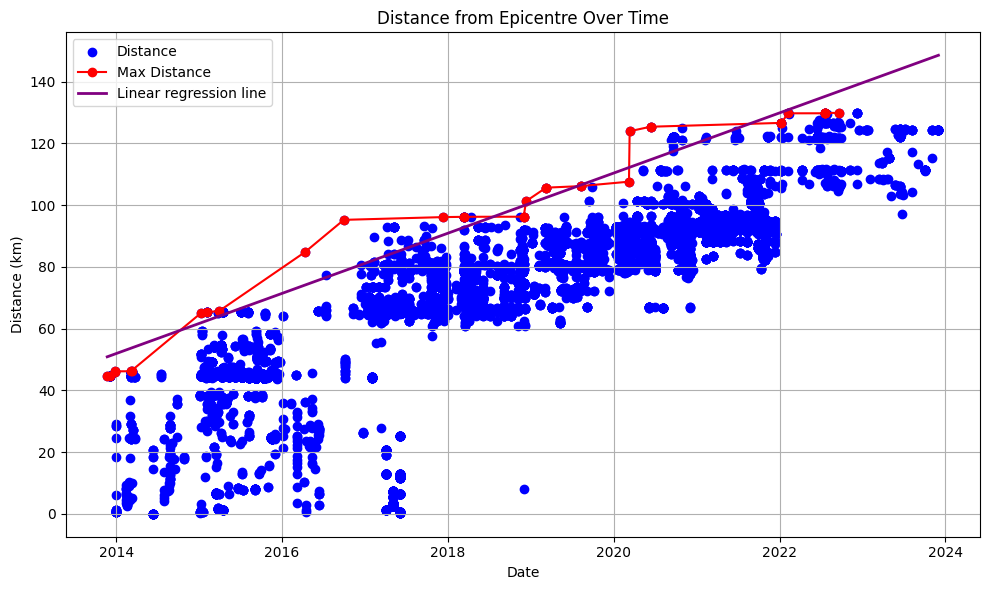

In [26]:
# CALCULATE SPEED OF DISEASE SPREAD
positives['ORDINAL'] = pd.to_datetime(positives['DATA_RILEVAMENTO']).apply(lambda x: x.toordinal())
X = df_max_distances[['ORDINAL']]
y = df_max_distances['DISTANCE']

model = linear_model.LinearRegression()
model.fit(X, y)

X_pred = positives[['ORDINAL']]
y_pred = model.predict(X_pred)

# PLOT ALL DISTANCES
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(positives['DATA_RILEVAMENTO'], positives['DISTANCE'], marker='o', linestyle='-', color='b', label='Distance')
ax.plot(df_max_distances['DATA_RILEVAMENTO'], df_max_distances['DISTANCE'], marker='o', linestyle='-', color='r', label='Max Distance')
ax.plot(positives['DATA_RILEVAMENTO'], y_pred, color='purple', linewidth=2, label='Linear regression line')
ax.set_xlabel('Date')
ax.set_ylabel('Distance (km)')
ax.set_title('Distance from Epicentre Over Time')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# # Plot only positive or negatives
# positives = data_concat[data_concat['RISULTATO'] == 'Positivo']
# negatives = data_concat[data_concat['RISULTATO'] == 'Negativo']

# lat_pos = positives['LATITUDINE'].values
# lon_pos = positives['LONGITUDINE'].values
# lat_neg = negatives['LATITUDINE'].values
# lon_neg = negatives['LONGITUDINE'].values

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# # create map using BASEMAP
# m1 = Basemap(llcrnrlon=lon_min,
#             llcrnrlat=lat_min,
#             urcrnrlon=lon_max,
#             urcrnrlat=lat_max,
#             lat_0=(lat_max - lat_min)/2,
#             lon_0=(lon_max-lon_min)/2,
#             projection='merc',
#             resolution = 'i',
#             area_thresh=10000.,
#             ax = ax[0]
#             )

# m1.drawcoastlines()
# m1.drawcountries()
# m1.drawstates()
# m1.drawmapboundary(fill_color='#46bcec')
# m1.fillcontinents(color='white',lake_color='#46bcec')

# lons_pos, lats_pos = m1(lon_pos, lat_pos)
# m1.scatter(lons_pos, lats_pos, c='red', marker='o', s=10, edgecolor='none', alpha=0.7)

# m2 = Basemap(llcrnrlon=lon_min,
#             llcrnrlat=lat_min,
#             urcrnrlon=lon_max,
#             urcrnrlat=lat_max,
#             lat_0=(lat_max - lat_min)/2,
#             lon_0=(lon_max-lon_min)/2,
#             projection='merc',
#             resolution = 'i',
#             area_thresh=10000.,
#             ax = ax[1]
#             )

# m2.drawcoastlines()
# m2.drawcountries()
# m2.drawstates()
# m2.drawmapboundary(fill_color='#46bcec')
# m2.fillcontinents(color='white',lake_color='#46bcec')

# lons_neg, lats_neg = m2(lon_neg, lat_neg)
# m2.scatter(lons_neg, lats_neg, c='green', marker='o', s=10, edgecolor='none', alpha=0.7)

# # Show the plot
# ax[0].set_title('Positive tests')
# ax[1].set_title('Negative tests')
# plt.show()


In [ ]:
# # PLOT SAMPLING YEAR BY YEAR

# color_map = {'Positivo': 'red', 'Negativo': 'green'}

# nrows = 3
# ncols = 4
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

# for i, year in enumerate(year_list):
#     yearly_data = data_concat[data_concat['DATA_RILEVAMENTO'].dt.year == year].copy()
    
#     lat = yearly_data['LATITUDINE'].values
#     lon = yearly_data['LONGITUDINE'].values
    
#     row = i // ncols
#     col = i % ncols
    
#     yearly_data['color'] = yearly_data['RISULTATO'].map(color_map)

#     m = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max,
#                 lat_0=(lat_max-lat_min)/2, lon_0=(lon_max-lon_min)/2,
#                 projection='merc', resolution = 'i', area_thresh=10000., ax=ax[row,col])
#     m.drawcoastlines()
#     m.drawcountries()
#     m.drawstates()
#     m.drawmapboundary(fill_color='#46bcec')
#     m.fillcontinents(color='white',lake_color='#46bcec')

#     lons, lats = m(lon, lat)
#     sc = m.scatter(lons, lats, c=yearly_data['color'].values, marker='o', s=0.2, edgecolor='none', alpha=0.7)

#     for condition in color_map:
#         ax[row,col].scatter([], [], c=color_map[condition], edgecolor='none', alpha=0.7, s=100, label=condition)
#     ax[row,col].legend(title='Condition', loc='lower left')

#     ax[row,col].set_title(f'Samples {year}')

# ax[-1,-1].axis('off')

# fig.suptitle('Yearly samples', fontsize=16)
# plt.show()

In [ ]:
# # PLOT POSITIVE SAMPLES 2013 WEEK BY WEEK

# year = 2014
# year_data = data_concat[data_concat['DATA_RILEVAMENTO'].dt.year == year]
# # date_list = year_data['DATA_RILEVAMENTO'].unique()
# week_list = year_data['SETTIMANA'].unique()
# positives = year_data[year_data['RISULTATO'] == 'Positivo']

# lat_min = 39.7
# lat_max = 40.4
# lon_min = 17.8
# lon_max = 18.5

# # for i, date in enumerate(date_list):
# for i, week in enumerate(week_list):
#     # daily_data = positives[positives['DATA_RILEVAMENTO'] == date].copy()
#     weekly_data = positives[positives['SETTIMANA'] == week].copy()

#     # print(f'Positive tests on {date}: {len(daily_data)}')
#     # print(f'Positive tests on week number {week}, {year}: {len(weekly_data)}')
    
#     # lat = daily_data['LATITUDINE'].values
#     # lon = daily_data['LONGITUDINE'].values
#     lat = weekly_data['LATITUDINE'].values
#     lon = weekly_data['LONGITUDINE'].values
    
#     fig, ax = plt.subplots(figsize=(6,6))
#     m = Basemap(llcrnrlon=lon_min,
#                 llcrnrlat=lat_min,
#                 urcrnrlon=lon_max,
#                 urcrnrlat=lat_max,
#                 lat_0=(lat_max-lat_min)/2,
#                 lon_0=(lon_max-lon_min)/2,
#                 projection='merc',
#                 resolution = 'l',
#                 area_thresh=10000.,
#                 ax=ax
#                 )

#     m.drawcoastlines()
#     m.drawcountries()
#     m.drawstates()
#     m.drawmapboundary(fill_color='#46bcec')
#     m.fillcontinents(color='white',lake_color='#46bcec')

#     lons, lats = m(lon, lat)
#     sc = m.scatter(lons, lats, c='r', marker='o', s=5, edgecolor='none', alpha=1)

#     # ax.set_title(f'Samples {date}')
#     ax.set_title(f'Positive samples in week number {week}, {year}: {len(weekly_data)}')
#     plt.show()

In [ ]:
# # CREATE WEEK COLUMN
# data_concat['SETTIMANA'] = data_concat['DATA_RILEVAMENTO'].dt.isocalendar().week

In [ ]:
# # PLOT DATES AND MAX DISTANCES

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(df_max_distances['DATA_RILEVAMENTO'], df_max_distances['DISTANCE'], marker='o', linestyle='-', color='b')#, label='Max Distance')
# ax.set_xlabel('Date')
# ax.set_ylabel('Max Distance (km)')
# ax.set_title('Maximum Distance from Epicentre Over Time')
# ax.grid(True)
# # ax.legend()
# plt.tight_layout()
# plt.show()